In [12]:
import rasterio as rio
from rasterio.plot import show
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mc
import glob
import cv2
import pandas as pd
# import KMeans
from sklearn.cluster import KMeans

## Functions

In [15]:
def plotDifferentClusters(img_arr, color_map, img_pred, img, imgName):    
    # 5–95% contrast stretchuh
    vmin, vmax = np.nanpercentile(img_arr, (5,95)) 
    # show the original and predicted image
    fig, (ax1,ax2) = plt.subplots(figsize=[15,15], nrows=1,ncols=2, sharey=False,)
    show(img, cmap='gray', vmin=vmin, vmax=vmax, ax=ax1)
    show(img_pred, cmap=color_map, ax=ax2)
    ax1.set_axis_off()
    ax2.set_axis_off()
    fig.savefig("img/"+imgName+"_clusterized.png", bbox_inches='tight')
    plt.show()

def plotClusterImg(img_cl, cmap, imgName):
    # Show the resulting array and save it as jpg image
    plt.figure(figsize=[20,20])
    plt.imshow(img_cl, cmap=cmap)
    plt.axis('off')
    plt.savefig("img/"+imgName+"_img_clf.png", bbox_inches='tight')
    plt.show()
    
def predictImg(cl, pathToImg, plotEachCluster, imgName):
    # open the raster image
    img = rio.open(pathToImg)
    # create an empty array with same dimensions and data type 
    img_xyb = np.empty((img.height, img.width,img.count), img.meta['dtype'])
    # loop through the raster bands and fill the empty array in x-y-bands order
    for band in range(img_xyb.shape[2]):
        img_xyb[:,:,band] = img.read(band+1)
    # convert to 1d array
    X = img_xyb[:,:,:1].reshape(img_xyb.shape[0]*img_xyb.shape[1], img_xyb.shape[2])
    # predict the clusters in the image 
    pred = cl.predict(X)
    # reshape the 1d array predictions to x-y-bands shape order (only one band)
    img_pred = pred.reshape(img_xyb[:,:,0].shape)

    img_arr = img.read() # Read the image
    
    if plotEachCluster :
        plotDifferentClusters(img_arr, fst_class, img_pred,img, "fst_class_"+imgName)
        plotDifferentClusters(img_arr, snd_class, img_pred,img, "snd_class_"+imgName)
        plotDifferentClusters(img_arr, trd_class, img_pred,img, "trd_class_"+imgName)
    else:
        plotDifferentClusters(img_arr, all_class, img_pred,img, "all_class_"+imgName)
           
    
    return img, img_arr, img_pred

# Select one of the images for train KMeans model

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: Invalid shape () for image data

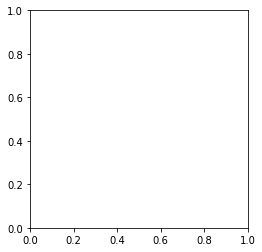

In [16]:
path = "/home/bruno/Documents/UBA/Reconocimiento de patrones/data TP-final/OneDrive-2022-01-08/20120612 GFPGR overexpress/CORT/19_CORT/"
directory = path + "*.tif"
img = [cv2.imread(file, cv2.IMREAD_UNCHANGED) for file in glob.glob(directory)]
del img[:10]
img = np.array(img)
img_mean = np.mean(img, axis=0)
img_mean = np.float32(img_mean)
plt.imshow(img_mean)
plt.axis("off")
img_mean.shape

In [4]:
img_mean

array([[0.06428572, 0.06428572, 0.06428572, ..., 0.39285713, 0.4857143 ,
        0.40714285],
       [0.06428572, 0.06428572, 0.06428572, ..., 0.40714285, 0.47142857,
        0.39285713],
       [0.08571429, 0.06428572, 0.07142857, ..., 0.55714285, 0.45      ,
        0.7       ],
       ...,
       [0.09285714, 0.07142857, 0.08571429, ..., 0.23571429, 0.29285714,
        0.20714286],
       [0.08571429, 0.10714286, 0.08571429, ..., 0.2857143 , 0.21428572,
        0.2       ],
       [0.10714286, 0.06428572, 0.05      , ..., 0.21428572, 0.27142859,
        0.27857143]], dtype=float32)

In [18]:
# Open the image 
open_img = rio.open("data/CamVid/trainannot/0001TP_007110.png")
print(open_img.meta)
# Read, enhance and show the image
open_img_arr = open_img.read() # read the opened image
vmin, vmax = np.nanpercentile(open_img_arr, (5,95))  # 5-95% contrast stretch# show the enhanced image
plt.figure(figsize=[10,10])
show(open_img, cmap='gray', vmin=vmin, vmax=vmax)

RasterioIOError: data/CamVid/trainannot/0001TP_007110.png: No such file or directory

In [57]:
np.unique(open_img_arr)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11], dtype=uint8)

In [58]:
mask = open_img_arr == 8
open_img_arr = open_img_arr * mask

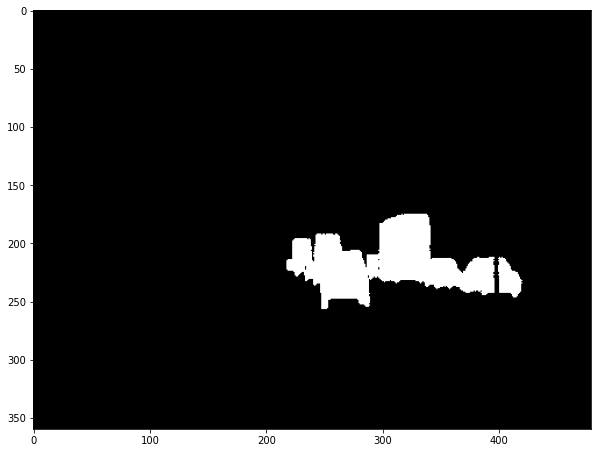

<AxesSubplot:>

In [61]:
plt.figure(figsize=[10,10])
show(open_img_arr, cmap='gray')

In [224]:
# create an empty array with same dimension and data type
imgxyb = np.empty((open_img.height, open_img.width, open_img.count)
                  , open_img.meta['dtype'])
# loop through the raster's bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = open_img.read(band+1)
    
print(imgxyb.shape)

# convert to 1d array for train de K-means clasiffier
X = imgxyb[:,:,:4].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))

print(X.shape)

(906, 905, 4)
(819930, 4)


## Find optimal number of clusters

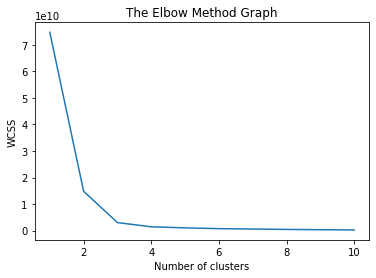

In [148]:
wcss=[]
#this loop will fit the k-means algorithm to our data and 
#second we will compute the within cluster sum of squares and 
#appended to our wcss list.
for i in range(1,11): 
    kmeans = cluster.KMeans(n_clusters=i, init ='k-means++', max_iter=500,  
            n_init=10,random_state=42 )
#i above is between 1-10 numbers. init parameter is the random
#initialization method  
#we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
#find the final clusters when the K-meands algorithm is running. 
#we enter the default value of 300
#the next parameter is n_init which is the number of times the 
#K_means algorithm will be run with
#different initial centroid.

    kmeans.fit(X)

#kmeans algorithm fits to the X dataset
    wcss.append(kmeans.inertia_)

#kmeans inertia_ attribute is:  Sum of squared distances of samples 
#to their closest cluster center.
#4.Plot the elbow graph
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

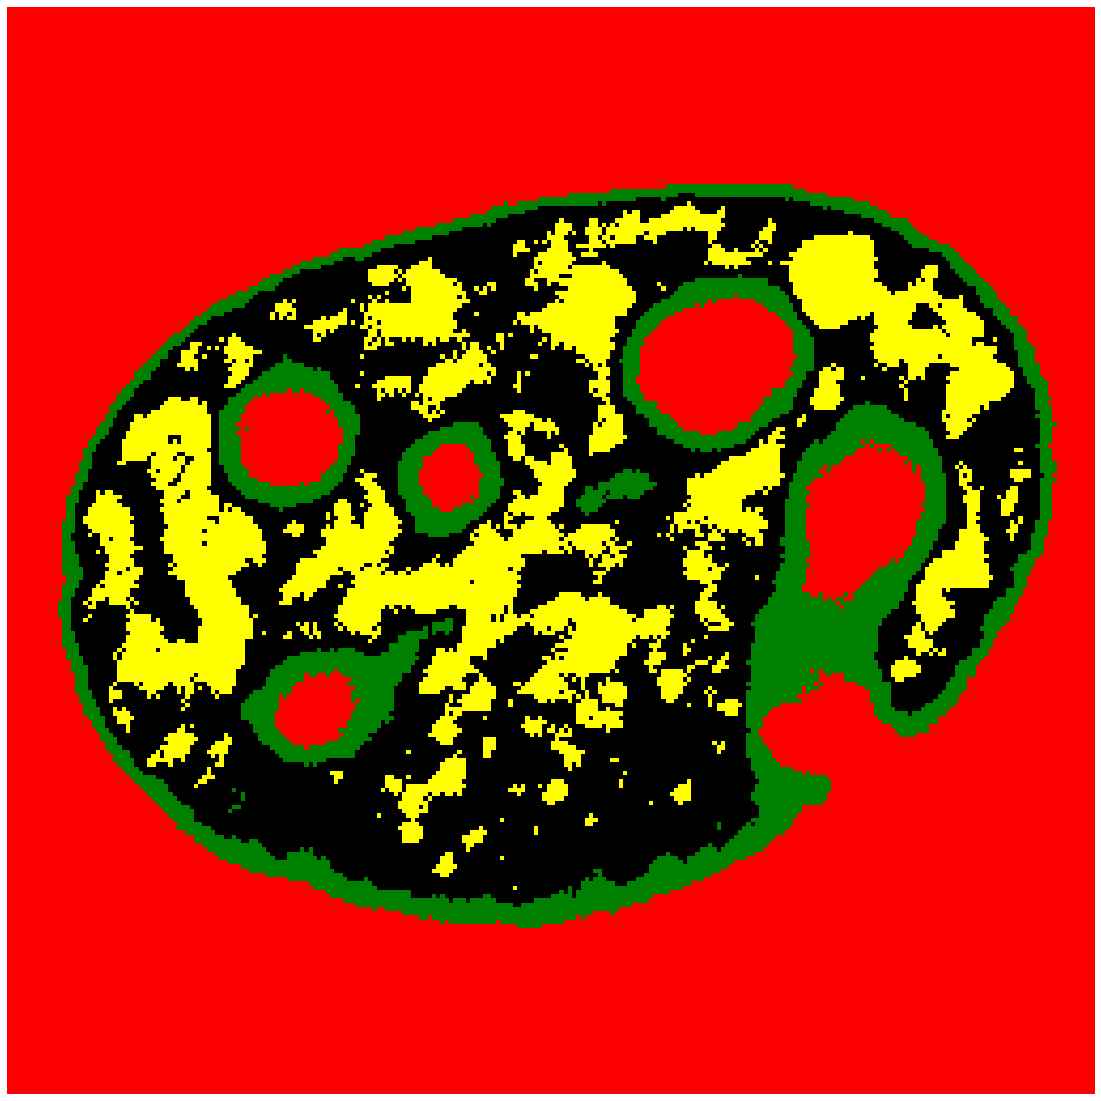

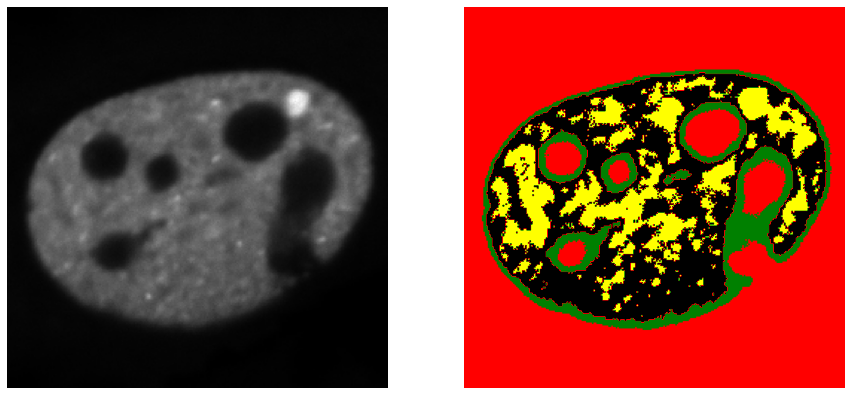

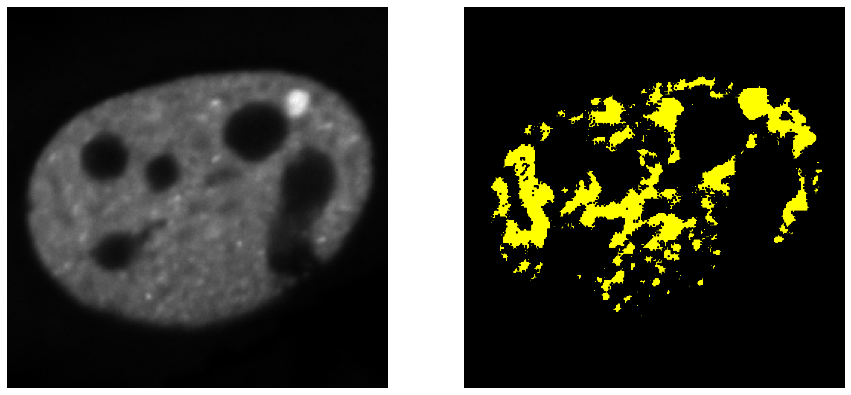

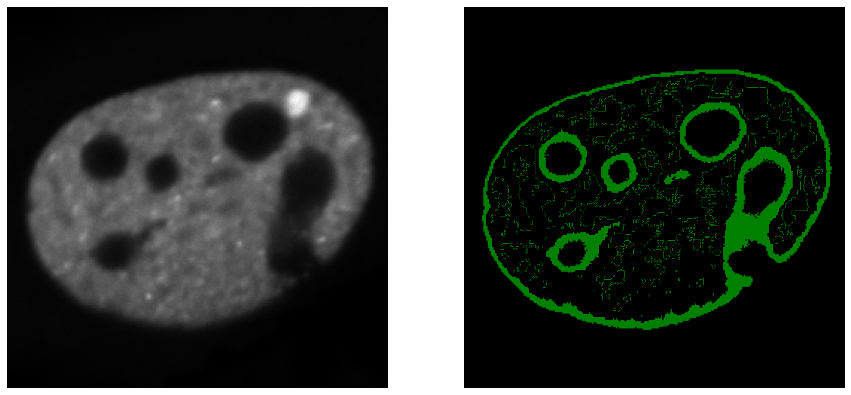

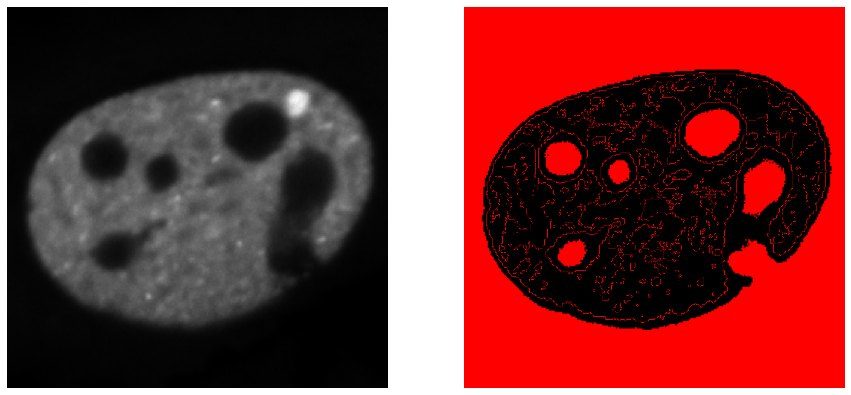

In [10]:
# create an object of the classifier
cl = cluster.KMeans(n_clusters=4, init ='k-means++', max_iter=500, 
                random_state=42 )
# train it
param = cl.fit(img_mean.flatten().reshape(-1,1)) 
# get the labels of the classes
img_cl = cl.labels_ 
# reshape labels to a 3d array (one band only)
img_cl = img_cl.reshape(img_mean.shape)

# Create a custom color map to represent our different 4 classes
all_class = mc.LinearSegmentedColormap.from_list("", ["black","red","green","yellow"])
fst_class = mc.LinearSegmentedColormap.from_list("", ["black","black","black","yellow"])
snd_class = mc.LinearSegmentedColormap.from_list("", ["black","black","green","black"])
trd_class = mc.LinearSegmentedColormap.from_list("", ["black","red","black","black"])

plotClusterImg(img_cl, all_class,"05_C001T150")

plotDifferentClusters(open_img_arr, all_class, img_cl,open_img,"all_class_05_C001T150")
plotDifferentClusters(open_img_arr, fst_class, img_cl,open_img,"fst_class_05_C001T150")
plotDifferentClusters(open_img_arr, snd_class, img_cl,open_img,"snd_class_05_C001T150")
plotDifferentClusters(open_img_arr, trd_class, img_cl,open_img,"trd_class_05_C001T150")

## Prediction for other images

/home/bruno/.local/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


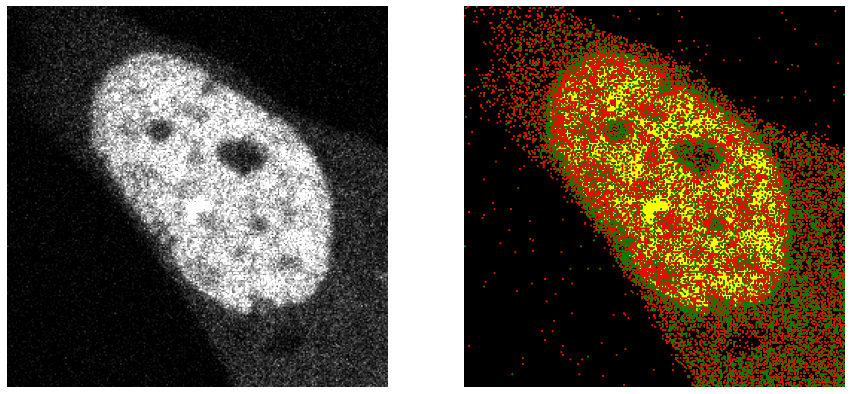

In [142]:
img, img_arr, img_pred = predictImg(cl, 'data_test5/GRtetra 05_C001T101.tif', False, "05_C001T101")
